In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
importlib.reload(src)

import src.model.metrics as metrics
import src.model.train as train
import src.model.ae as ae
import src.model.gau as gaussian
import src.model.linear_probing as lp
import src.plots as plots


In [4]:
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')
dataset_1_21 = pd.read_pickle('data/stamp_dataset_21_new.pkl')

In [4]:
def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

rename_labels(stamps_dataset, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

In [3]:
importlib.reload(gaussian)

# generate fake gaussian dataset
num_samples = 15000
image_size = 21
border_margin = 4
noise_level = 0.1
brightness = 0.7

gaussian_images = gaussian.generate_gaussian_dataset(num_samples, image_size, border_margin, noise_level, brightness)
gaussian_dataset = TensorDataset(gaussian_images)

In [4]:
train_dataset_0 = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
validation_dataset_0 = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
test_dataset_0 = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)

train_class_0 = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)
validation_class_0 = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)
test_class_0 = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

#normalize between 0 and 1
train_difference = (train_dataset_0 - train_dataset_0.min()) / (train_dataset_0.max() - train_dataset_0.min())
validation_difference = (validation_dataset_0 - validation_dataset_0.min()) / (validation_dataset_0.max() - validation_dataset_0.min())
test_difference = (test_dataset_0 - test_dataset_0.min()) / (test_dataset_0.max() - test_dataset_0.min())

# Reshape the arrays to separate timestamps
num_samples, num_photos, height, width = train_difference.shape
reshaped_train_difference = train_difference.reshape(num_samples * num_photos, 1, height, width)
reshaped_train_class = train_class_0.repeat_interleave(num_photos)

num_samples, num_photos, height, width = validation_difference.shape
reshaped_val_difference = validation_difference.reshape(validation_difference.shape[0] * num_photos, 1, height, width)
reshaped_val_class = validation_class_0.repeat_interleave(num_photos)

num_samples, num_photos, height, width = test_difference.shape
reshaped_test_difference = test_difference.reshape(test_difference.shape[0] * num_photos, 1, height, width)
reshaped_test_class = test_class_0.repeat_interleave(num_photos)

train_dataset_0 = TensorDataset(reshaped_train_difference, reshaped_train_class)
validation_dataset_0 = TensorDataset(reshaped_val_difference, reshaped_val_class)
test_dataset_0 = TensorDataset(reshaped_test_difference, reshaped_test_class)

KeyError: 'class'

In [10]:
train_difference = torch.tensor(dataset_1_21['Train']['images'], dtype=torch.float32)
validation_difference = torch.tensor(dataset_1_21['Validation']['images'], dtype=torch.float32)
test_difference = torch.tensor(dataset_1_21['Test']['images'], dtype=torch.float32)

train_class_1 = torch.tensor(dataset_1_21['Train']['class'], dtype=torch.float32)
validation_class_1 = torch.tensor(dataset_1_21['Validation']['class'], dtype=torch.float32)
test_class_1 = torch.tensor(dataset_1_21['Test']['class'], dtype=torch.float32)

train_difference = (train_difference - train_difference.min()) / (train_difference.max() - train_difference.min())
validation_difference = (validation_difference - validation_difference.min()) / (validation_difference.max() - validation_difference.min())
test_difference = (test_difference - test_difference.min()) / (test_difference.max() - test_difference.min())


# Seleccionar los canales 0 y 2
train_difference_reshaped = train_difference[:, :, :, [0, 2]]
validation_difference_reshaped = validation_difference[:, :, :, [0, 2]]
test_difference_reshaped = test_difference[:, :, :, [0, 2]]

# Permutar las dimensiones para que tengan la forma [batch_size, num_channels, height, width]
train_difference_reshaped_perm = train_difference_reshaped.permute(0, 3, 1, 2)
validation_difference_reshaped_perm = validation_difference_reshaped.permute(0, 3, 1, 2)
test_difference_reshaped_perm = test_difference_reshaped.permute(0, 3, 1, 2)

train_dataset_1 = TensorDataset(train_difference_reshaped_perm, train_class_1)
validation_dataset_1 = TensorDataset(validation_difference_reshaped_perm, validation_class_1)
test_dataset_1 = TensorDataset(test_difference_reshaped_perm, test_class_1)

print(train_dataset_1.tensors[0].shape)

print(validation_dataset_1.tensors[0].shape)

print(test_dataset_1.tensors[0].shape)

torch.Size([72710, 2, 21, 21])
torch.Size([500, 2, 21, 21])
torch.Size([500, 2, 21, 21])


In [96]:
test_model_1_1 = ae.AE(latent_dim=30, n_channels=2, name='test_model_1_1')
test_model_1_2 = ae.AE(latent_dim=30, n_channels=2, name='test_model_1_2')
test_model_1_3 = ae.AE(latent_dim=30, n_channels=2, name='test_model_1_3')

test_model_1_1.load_state_dict(torch.load('models/model_1_1.pth'))
test_model_1_1.eval()

test_model_1_2.load_state_dict(torch.load('models/model_1_2.pth'))
test_model_1_2.eval()

test_model_1_3.load_state_dict(torch.load('models/model_1_3.pth'))
test_model_1_3.eval()

test_models_1 = [test_model_1_1, test_model_1_2, test_model_1_3]



test_model_2_1 = ae.AE(latent_dim=10, n_channels=2, name='test_model_2_1')
test_model_2_2 = ae.AE(latent_dim=21, n_channels=2, name='test_model_2_2')
test_model_2_3 = ae.AE(latent_dim=42, n_channels=2, name='test_model_2_3')

test_model_2_1.load_state_dict(torch.load('models/model_2_1.pth'))
test_model_2_1.eval()

test_model_2_2.load_state_dict(torch.load('models/model_2_2.pth'))
test_model_2_2.eval()

test_model_2_3.load_state_dict(torch.load('models/model_2_3.pth'))
test_model_2_3.eval()

test_models_2 = [test_model_2_1, test_model_2_2, test_model_2_3]


test_model_3_1 = ae.AE(latent_dim=42, n_channels=2, name='test_model_3_1')
test_model_3_2 = ae.AE(latent_dim=42, n_channels=2, name='test_model_3_2')
test_model_3_3 = ae.AE(latent_dim=42, n_channels=2, name='test_model_3_3')

test_model_3_1.load_state_dict(torch.load('models/model_3_1.pth'))
test_model_3_1.eval()

test_model_3_2.load_state_dict(torch.load('models/model_3_2.pth'))
test_model_3_2.eval()

test_model_3_3.load_state_dict(torch.load('models/model_3_3.pth'))
test_model_3_3.eval()

test_models_3 = [test_model_3_1, test_model_3_2, test_model_3_3]




/tmp/ipykernel_660827/3990284273.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_1_1.load_state_dict(torch.load('models/model_1_1.pth'))
/tmp/ipykernel_660827

In [17]:
# linear probing settings
lp_epochs = 200
lp_criterion = nn.CrossEntropyLoss()
lp_batch_size = 100
lp_lr = 0.333e-4
use_gpu = False

In [8]:
importlib.reload(lp)

train_1, val_1, test_1 = lp.get_latent_features(test_models, train_dataset_1, validation_dataset_1, test_dataset_1)


lp_model_1_1 = lp.LinearClassifier(30, 5, 'test_model_1')
lp_model_1_2 = lp.LinearClassifier(30, 5, 'test_model_2')
lp_model_1_3 = lp.LinearClassifier(30, 5, 'test_model_3')

lp_curves_1_1, lp_tiempo_1_1, lp_labels_1_1, lp_pred_1_1 = lp.train_model(lp_model_1_1, train_1[0], val_1[0], test_1[0], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
lp_curves_1_2, lp_tiempo_1_2, lp_labels_1_2, lp_pred_1_2 = lp.train_model(lp_model_1_2, train_1[1], val_1[1], test_1[1], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
lp_curves_1_3, lp_tiempo_1_3, lp_labels_1_3, lp_pred_1_3 = lp.train_model(lp_model_1_3, train_1[2], val_1[2], test_1[2], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)

lp_models_1 = [lp_model_1_1, lp_model_1_2, lp_model_1_3]
matrix_1 = [confusion_matrix(lp_labels_1_1, lp_pred_1_1), confusion_matrix(lp_labels_1_2, lp_pred_1_2), confusion_matrix(lp_labels_1_3, lp_pred_1_3)]

Epoch 200/200 -- Iteration 145600 - Batch 727/728 - Train loss: 0.985906 - Val loss: 0.9128

Epoch 200/200 -- Iteration 145600 - Batch 727/728 - Train loss: 0.962196 - Val loss: 0.8853

Epoch 200/200 -- Iteration 145600 - Batch 727/728 - Train loss: 1.258223 - Val loss: 0.8775



In [98]:
importlib.reload(metrics)
importlib.reload(plots)
importlib.reload(lp)


lp_model_1_1 = lp.LinearClassifier(30, 5, "lp_model_1_1")
lp_model_1_1.load_state_dict(torch.load('models/lp_model_1_1.pth'))
lp_model_1_1.eval()
lp_model_1_2 = lp.LinearClassifier(30, 5, "lp_model_1_2")
lp_model_1_2.load_state_dict(torch.load('models/lp_model_1_2.pth'))
lp_model_1_2.eval()
lp_model_1_3 = lp.LinearClassifier(30, 5, "lp_model_1_3")
lp_model_1_3.load_state_dict(torch.load('models/lp_model_1_3.pth'))
lp_model_1_3.eval()

lp_model_2_1 = lp.LinearClassifier(10, 5, "lp_model_2_1")
lp_model_2_1.load_state_dict(torch.load('models/lp_model_2_1.pth'))
lp_model_2_1.eval()
lp_model_2_2 = lp.LinearClassifier(21, 5, "lp_model_2_2")
lp_model_2_2.load_state_dict(torch.load('models/lp_model_2_2.pth'))
lp_model_2_2.eval()
lp_model_2_3 = lp.LinearClassifier(42, 5, "lp_model_2_3")
lp_model_2_3.load_state_dict(torch.load('models/lp_model_2_3.pth'))
lp_model_2_3.eval()


lb_model_3_1 = lp.LinearClassifier(42, 5, "lp_model_3_1")
lb_model_3_1.load_state_dict(torch.load('models/lp_model_3_1.pth'))
lb_model_3_1.eval()
lb_model_3_2 = lp.LinearClassifier(42, 5, "lp_model_3_2")
lb_model_3_2.load_state_dict(torch.load('models/lp_model_3_2.pth'))
lb_model_3_2.eval()
lb_model_3_3 = lp.LinearClassifier(42, 5, "lp_model_3_3")
lb_model_3_3.load_state_dict(torch.load('models/lp_model_3_3.pth'))
lb_model_3_3.eval()


lp_models = [lp_model_1_1, lp_model_1_2, lp_model_1_3, lp_model_2_1, lp_model_2_2, lp_model_2_3, lb_model_3_1, lb_model_3_2, lb_model_3_3]

train_1, val_1, test_1 = lp.get_latent_features(test_models_1, train_dataset_1, validation_dataset_1, test_dataset_1)
train_2, val_2, test_2 = lp.get_latent_features(test_models_2, train_dataset_1, validation_dataset_1, test_dataset_1)
train_3, val_3, test_3 = lp.get_latent_features(test_models_3, train_dataset_1, validation_dataset_1, test_dataset_1)

train_datasets = [train_1, train_2, train_3]  
val_datasets = [val_1, val_2, val_3]            
test_datasets = [test_1, test_2, test_3] 

/tmp/ipykernel_660827/1281742115.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lp_model_1_1.load_state_dict(torch.load('models/lp_model_1_1.pth'))
/tmp/ipykernel_66082

In [104]:
## Metrics test 

for i in range(1, 4):
    for model_num in range(1, 4):
        model = lp_models[(i-1)*3 + model_num - 1]
        print(f"model: {model.name}")
        print(f"train_datasets[{i-1}][{model_num-1}]")
        print(f"train_datasets[{i-1}][{model_num-1}]")
        print(f"train_datasets[{i-1}][{model_num-1}]")
        lp_curves, lp_tiempo, lp_labels, lp_pred = lp.train_model(model, 
                                                                  train_datasets[i-1][model_num-1], 
                                                                  val_datasets[i-1][model_num-1], 
                                                                  test_datasets[i-1][model_num-1], 
                                                                  lp_epochs, 
                                                                  lp_criterion, 
                                                                  lp_batch_size, 
                                                                  lp_lr, 
                                                                  use_gpu)
        
        perf = metrics.performance_metrics(true_labels=lp_labels, prediction=lp_pred)
        print(f'Group {i}, Model {model_num}: Precision: {perf[0]}, Recall: {perf[1]}, F1: {perf[2]}')
        


model: lp_model_1_1
train_datasets[0][0]
train_datasets[0][0]
train_datasets[0][0]
Epoch 1/200 -- Iteration 98 - Batch 98/728 - Train loss: 0.9235

Epoch 200/200 -- Iteration 145600 - Batch 727/728 - Train loss: 0.392909 - Val loss: 0.8901

Group 1, Model 1: Precision: 0.72795, Recall: 0.71298, F1: 0.71086
model: lp_model_1_2
train_datasets[0][1]
train_datasets[0][1]
train_datasets[0][1]
Epoch 200/200 -- Iteration 145600 - Batch 727/728 - Train loss: 1.246608 - Val loss: 0.8753

Group 1, Model 2: Precision: 0.72623, Recall: 0.71702, F1: 0.71389
model: lp_model_1_3
train_datasets[0][2]
train_datasets[0][2]
train_datasets[0][2]
Epoch 200/200 -- Iteration 145600 - Batch 727/728 - Train loss: 0.651889 - Val loss: 0.8711

Group 1, Model 3: Precision: 0.7245, Recall: 0.71246, F1: 0.71088
model: lp_model_2_1
train_datasets[1][0]
train_datasets[1][0]
train_datasets[1][0]
Epoch 200/200 -- Iteration 145600 - Batch 727/728 - Train loss: 1.093608 - Val loss: 1.1314

Group 2, Model 1: Precision: 0.64673, Recall: 0.62684, F1: 0.62403
model: lp_model_2_2
train_datasets[1][1]
train_datasets[1][1]
train_datasets[1][1]
Epoch 200/200 -- Iteration 14

In [15]:
lista = [[1,2], [3,4], [5,6]]
print(lista[0][1])

2


In [21]:
## model 2_4 (me falto)

test_model_2_4 = ae.AE(latent_dim=130, n_channels=2, name='test_model_2_4')

test_model_2_4.load_state_dict(torch.load('models/model_2_4.pth'))
test_model_2_4.eval()
lp_model_2_4 = lp.LinearClassifier(130, 5, "lp_model_2_4")
lp_model_2_4.load_state_dict(torch.load('models/lp_model_2_4.pth'))
lp_model_2_4.eval()

train_2, val_2, test_2 = lp.get_latent_features([test_model_2_4], train_dataset_1, validation_dataset_1, test_dataset_1)


lp_curves_2_4, lp_tiempo_2_4, lp_labels_2_4, lp_pred_2_4 = lp.train_model(lp_model_2_4, train_2[0], val_2[0], test_2[0], lp_epochs, lp_criterion, lp_batch_size, lp_lr, use_gpu)
print(f' Precision: {perf[0]}, Recall: {perf[1]}, F1: {perf[2]}')

/tmp/ipykernel_877570/1570843551.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model_2_4.load_state_dict(torch.load('models/model_2_4.pth'))
/tmp/ipykernel_877570

Epoch 200/200 -- Iteration 145600 - Batch 727/728 - Train loss: 0.313084 - Val loss: 0.6984

 Precision: 0.76275, Recall: 0.75439, F1: 0.75238


 Precision: 0.76275, Recall: 0.75439, F1: 0.75238


In [30]:
# settings

#umap 
n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
norm = True

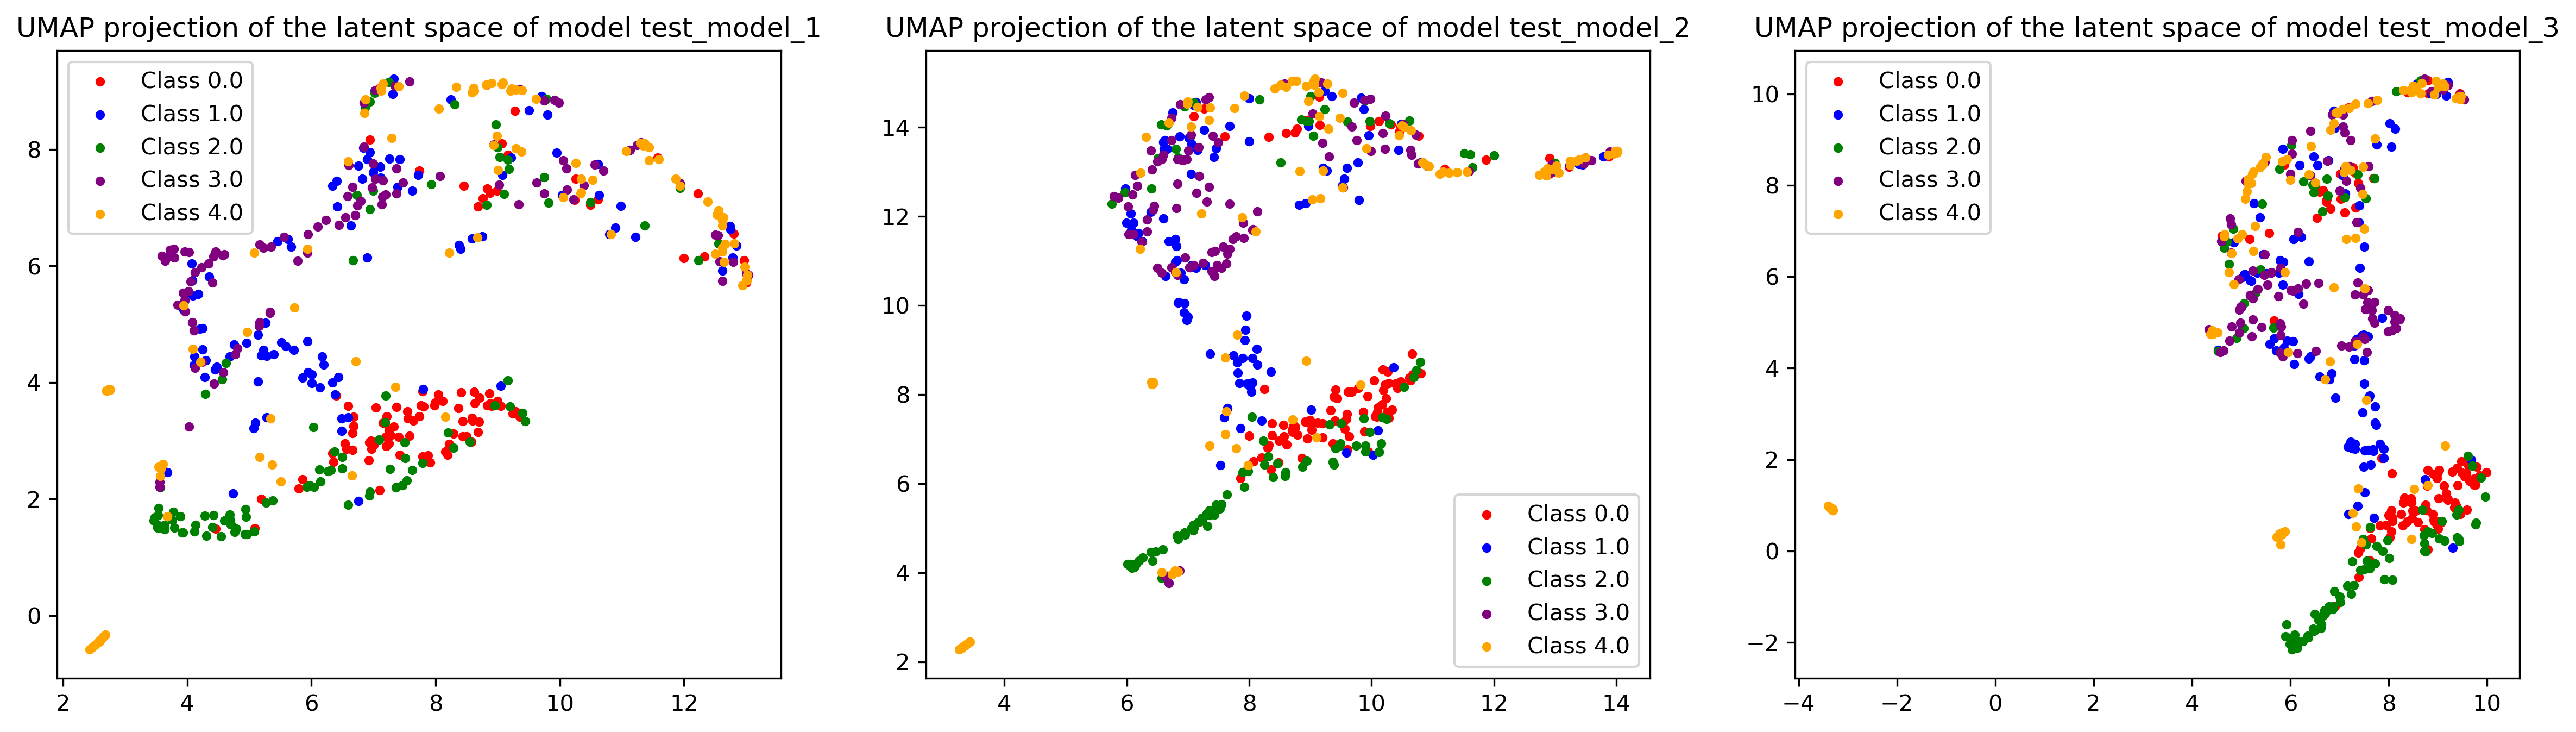

In [92]:
importlib.reload(metrics)
importlib.reload(plots)

metrics.plot_umap(test_models, test_dataset_1.tensors[0], test_class_1, n_neighbors, min_dist, metric, norm)
print()

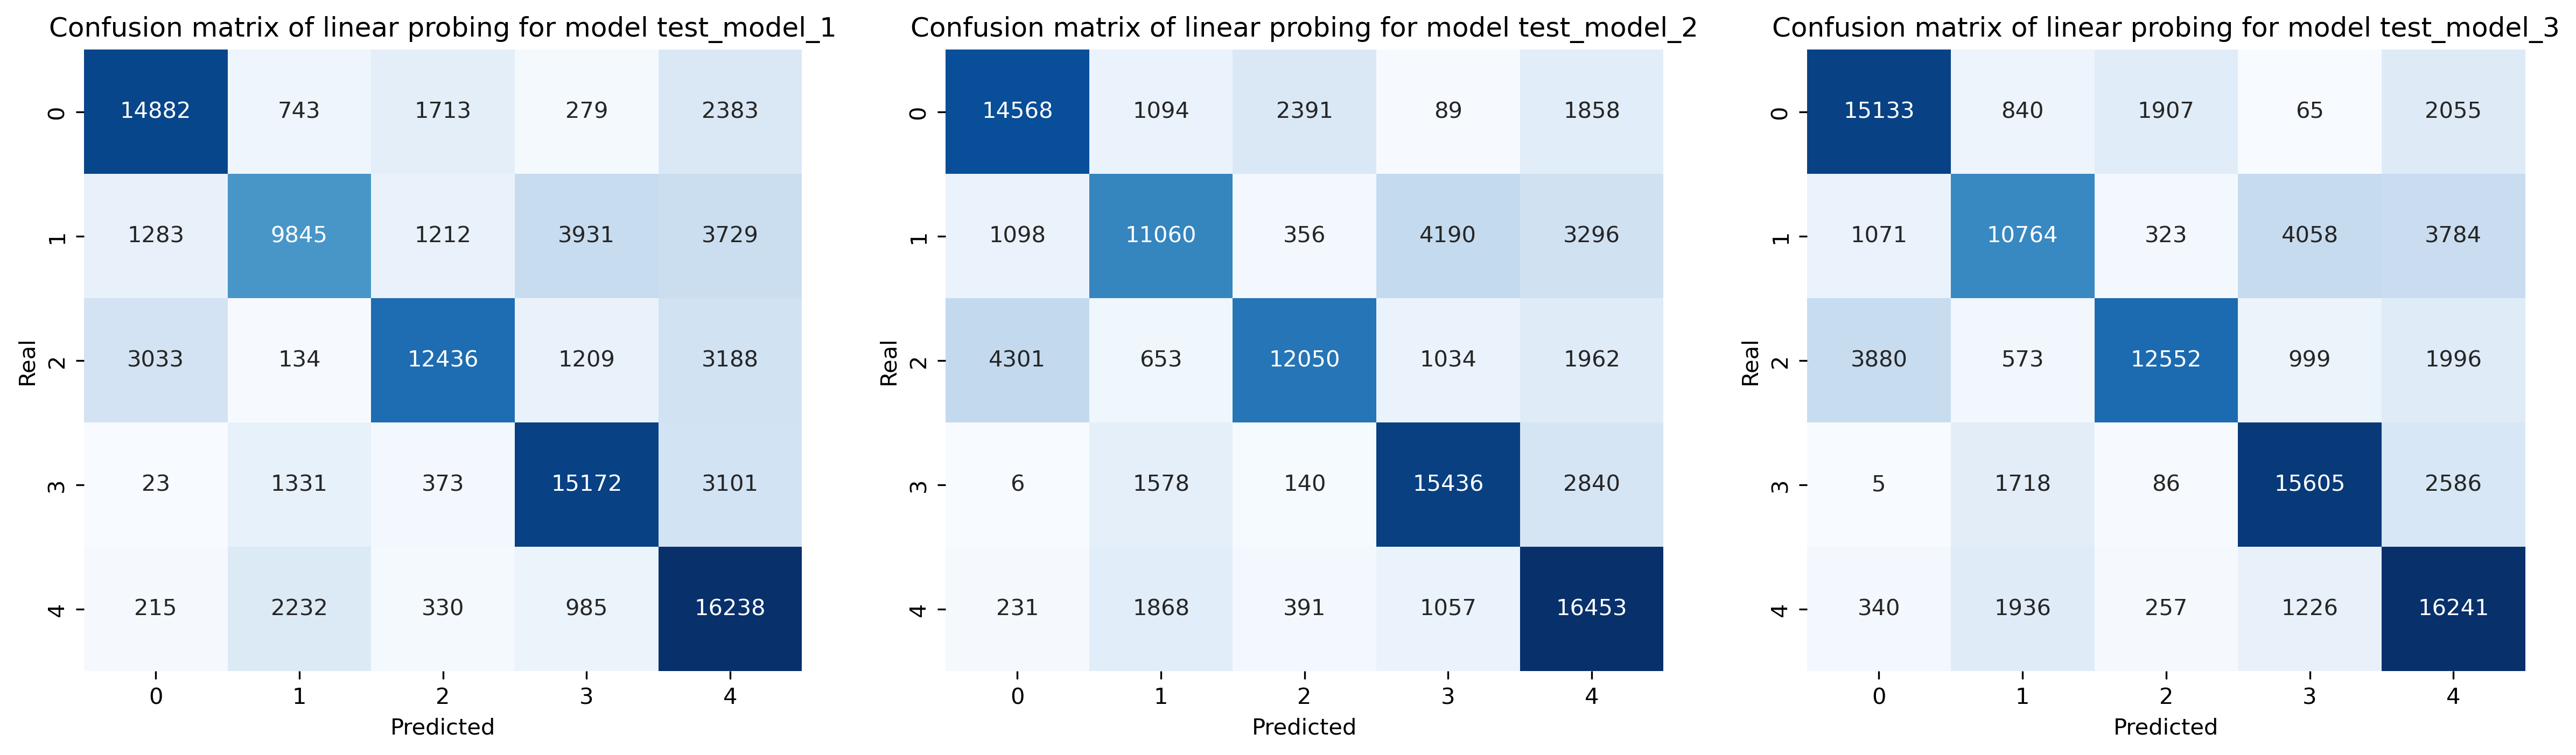

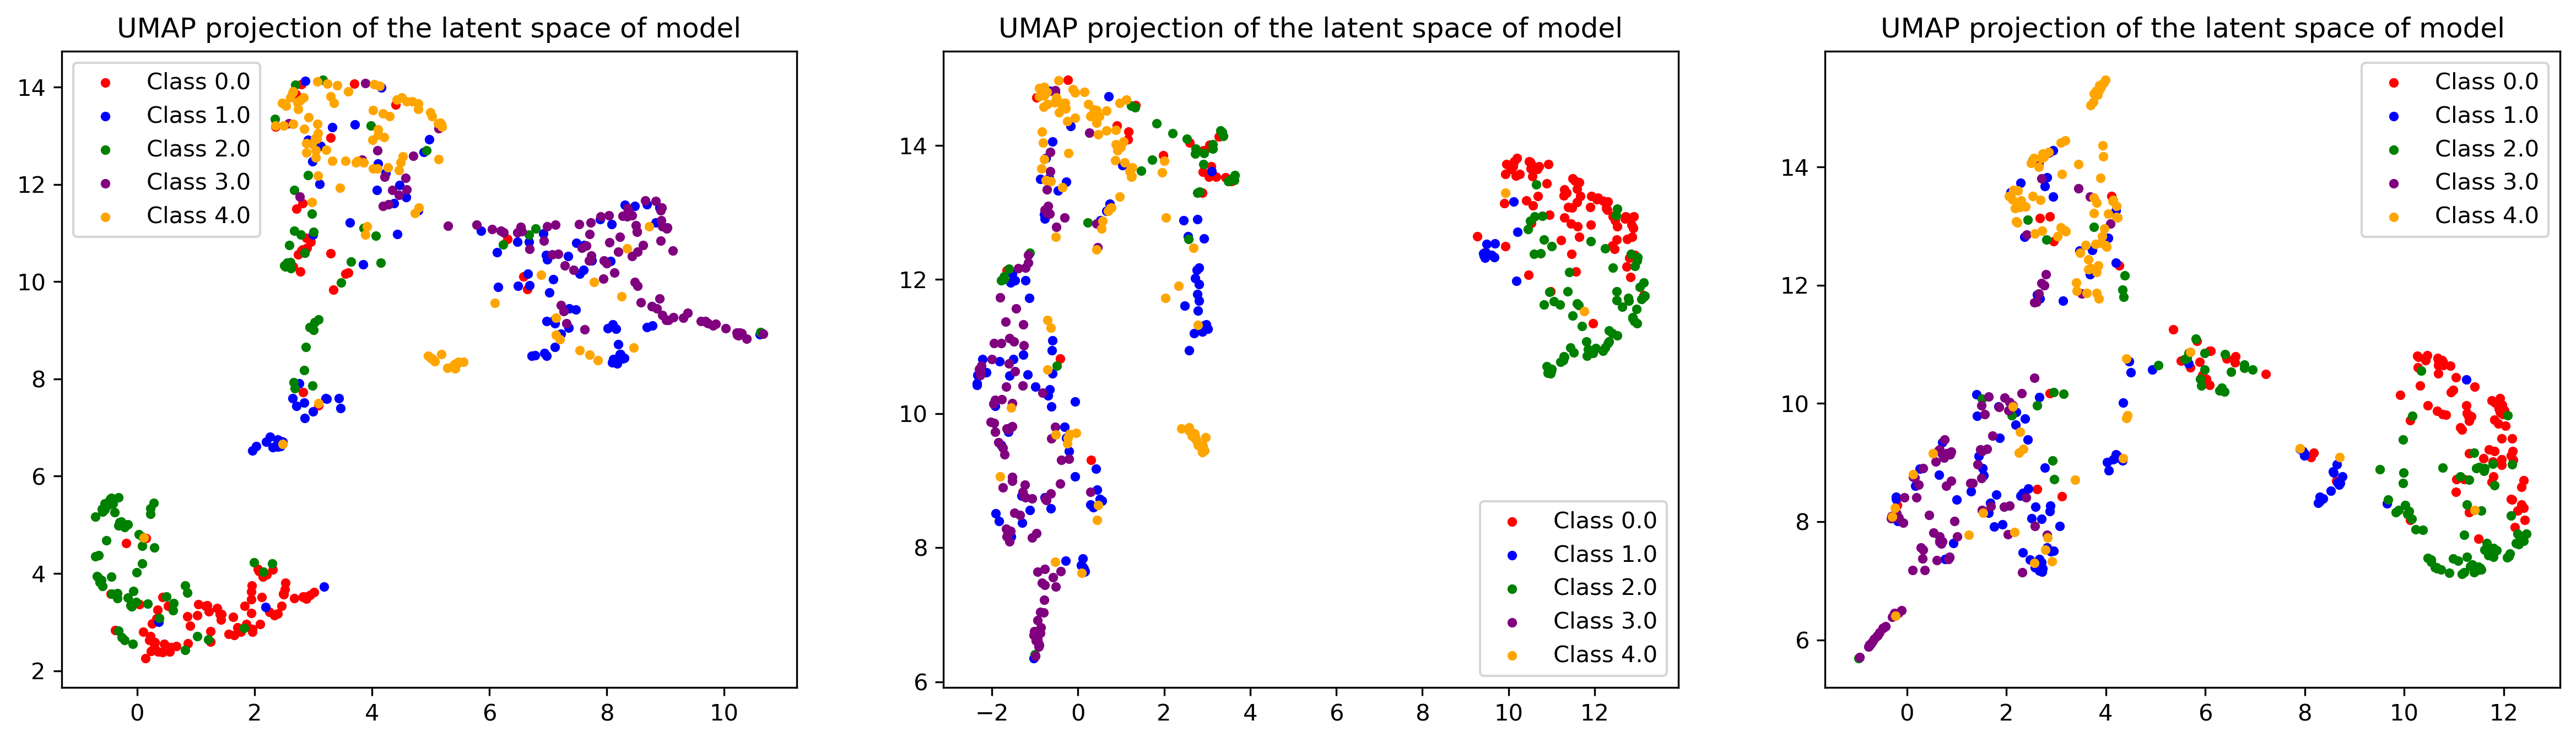

In [85]:


metrics.plot_matrix(test_models, matrix_1)
metrics.plot_umap_lp(lp_models_1, val_1, n_neighbors, min_dist, metric, norm)
print()

In [89]:
importlib.reload(metrics)
importlib.reload(plots)

plots.plot_example(test_models, test_dataset_1)